<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Investigate-shotgun-separately" data-toc-modified-id="Investigate-shotgun-separately-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Investigate shotgun separately</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v5.nc'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)


# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=90)
wgs_stats = ranking(wgs_diffs, reference_percentile=90)

Overlap in all of the taxa

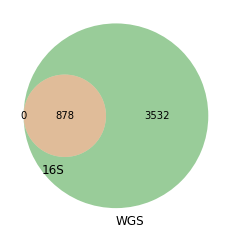

In [3]:
# Venn diagram to visualize overlap
venn2([set(amp_diffs.index), 
       set(wgs_diffs.index)], 
      set_labels=['16S', 'WGS'])

In [4]:
common_taxa = list(set(amp_diffs.index) & set(wgs_diffs.index))

In [5]:
amp_diffs_c = amp_diffs.loc[common_taxa]
wgs_diffs_c = wgs_diffs.loc[common_taxa]

amp_stats_c = amp_stats.loc[common_taxa]
wgs_stats_c = wgs_stats.loc[common_taxa]

Average log-fold changes

In [6]:
amp_idx = np.logical_and(amp_stats_c['pvalue'] < 0.001, amp_stats_c['tstat'] > 0)
wgs_idx = np.logical_and(wgs_stats_c['pvalue'] < 0.001, wgs_stats_c['tstat'] > 0)

Text(0, 0.5, '% Common taxa')

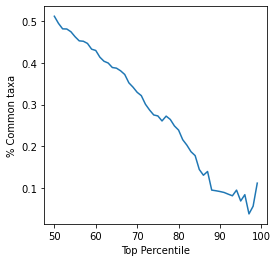

In [7]:
def overlap_f(x, y, q=100):
    x_thres = np.percentile(x.values, q)
    y_thres = np.percentile(y.values, q)
    x_set = set(x.loc[x > x_thres].index)
    y_set = set(y.loc[y > y_thres].index)
    # print(x_thres, y_thres, len(x_set & y_set), len(x_set), len(y_set))
    return len(x_set & y_set) / len(x_set)

spacing = np.linspace(50, 99, 50)
overlaps = [overlap_f(amp_stats_c['mean'], wgs_stats_c['mean'], q) for q in spacing]

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(spacing, overlaps)
ax.set_xlabel('Top Percentile')
ax.set_ylabel('% Common taxa')

In [8]:
int_amp = list(set(amp_stats_c.loc[amp_idx].index) & set(wgs_stats_c.loc[wgs_idx].index))

Overlap in significant taxa

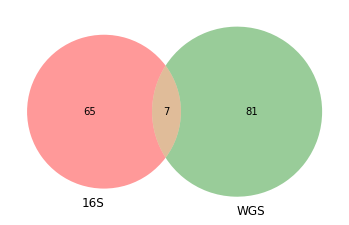

In [9]:
# Venn diagram to visualize overlap
venn2([set(amp_stats_c.loc[amp_idx].index), 
       set(wgs_stats_c.loc[wgs_idx].index)], 
      set_labels=['16S', 'WGS'])

In [10]:
amp_thres = amp_stats_c.loc[amp_idx, 'mean'].min()
wgs_thres = wgs_stats_c.loc[wgs_idx, 'mean'].min()
amp_max = amp_stats_c.loc[amp_idx, 'mean'].max()
wgs_max = wgs_stats_c.loc[wgs_idx, 'mean'].max()

In [11]:
amp_thres, wgs_thres, amp_max, wgs_max

(1.379696998953192, 0.7529781638539339, 5.497339106453191, 2.2723983848539335)

In [12]:
amp_stats_c['mean'].max()

5.497339106453191

Text(0, 0.5, 'SMS log fold change')

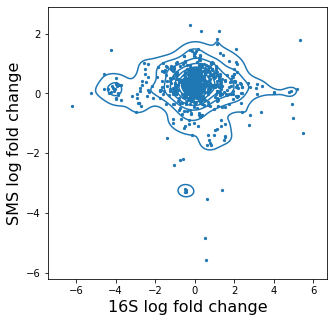

In [13]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(5, 5))
common_data = pd.DataFrame({
    'WGS' : wgs_stats_c['mean'],
    '16S' : amp_stats_c['mean']
})
sns.kdeplot(data=common_data, x="16S", y="WGS", ax=ax)
plt.scatter(common_data['16S'], common_data['WGS'], s=5)
#plt.plot(np.linspace(-10, 10), np.linspace(-10, 10), 'r')
#rect = Rectangle(xy=(amp_thres, wgs_thres), 
#                 width=amp_max-amp_thres, height=wgs_max-wgs_thres, 
#                 fc='red', alpha=0.5)
#ax.add_patch(rect)
ax.set_xlabel('16S log fold change', fontsize=16)
ax.set_ylabel('SMS log fold change', fontsize=16)

Correlations on the average log fold changes

In [20]:
pearsonr(amp_stats_c['mean'], wgs_stats_c['mean'])

(-0.023650932180654994, 0.4839886177895695)

In [15]:
spearmanr(amp_stats_c['mean'], wgs_stats_c['mean'])

SpearmanrResult(correlation=-0.02957825451632711, pvalue=0.38136820431738905)

Correlations on all of the posterior samples

In [16]:
pearsonr(amp_diffs_c.values.ravel(), wgs_diffs_c.values.ravel())

(-0.019450957412894748, 9.52208479721859e-31)

In [17]:
spearmanr(amp_diffs_c.values.ravel(), wgs_diffs_c.values.ravel())

SpearmanrResult(correlation=-0.014224505090433425, pvalue=3.452487056886905e-17)

# Investigate shotgun separately

In [18]:
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping2 = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)

In [19]:
wgs_peek = pd.merge(mapping2.set_index('genome'), wgs_stats, left_index=True, right_index=True)

In [20]:
pd.options.display.max_rows = 999
#mapping.set_index('genome').loc[int_amp].sort_values('family')

In [21]:
wgs_peek.sort_values('tstat', ascending=False).drop_duplicates().head(99)

,GOTU,kingdom,phylum,class,order,family,genus,species,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue
1262927,G000437495,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella sp. CAG:485,5.312233,1.108670,3.680634,5.325216,7.006519,4.321879,0.813571,86.940577,1.993703e-261
1643450,G001185205,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Hyphomicrobiaceae,Devosia,Devosia sp. H5989,2.247354,0.451070,1.547579,2.254792,3.024542,11.045454,4.914870,77.794626,3.079083e-243
1262870,G000434475,Bacteria,Firmicutes,Negativicutes,Veillonellales,Veillonellaceae,Dialister,Dialister sp. CAG:486,1.047456,0.163737,0.803824,1.041440,1.314681,39.069879,37.299794,67.747987,5.797480e-221
1123499,G000382305,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Vitreoscilla,Vitreoscilla stercoraria,1.340683,0.290676,0.873609,1.330619,1.809641,15.867456,11.835355,58.337757,1.995751e-197
155892,G001449105,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Caulobacter,Caulobacter vibrioides,1.408789,0.327369,0.897836,1.413666,1.906848,13.145334,9.330947,55.959889,5.341074e-191
398579,G000018285,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,Shewanella pealeana,0.919045,0.161189,0.661280,0.916661,1.174048,35.372363,38.488184,52.885845,2.277176e-182
654,G001593245,Bacteria,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,Aeromonas veronii,1.190895,0.271134,0.701999,1.204479,1.599445,16.199685,13.602949,51.493567,2.460623e-178
1124983,G000397205,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas protegens,1.196301,0.284524,0.719212,1.207671,1.647075,14.777592,12.352736,49.450229,2.877807e-172
1855376,G900113595,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,Lachnospiraceae bacterium NLAE-zl-G231,0.836473,0.150234,0.571181,0.841396,1.091486,37.060858,44.306105,45.749950,8.310162e-161
406817,G000252955,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Morganellaceae,Xenorhabdus,Xenorhabdus nematophila,0.835330,0.150131,0.588829,0.834848,1.089548,37.060773,44.366631,45.628914,2.019188e-160


In [22]:
idx = np.logical_and(wgs_peek.tstat > 0, wgs_peek.pvalue < 1e-10)
wgs_subpeek = wgs_peek.loc[idx]

In [23]:
wgs_subpeek.to_csv('wgs_taxa.csv')

Text(0.5, 0, 'Number of Families')

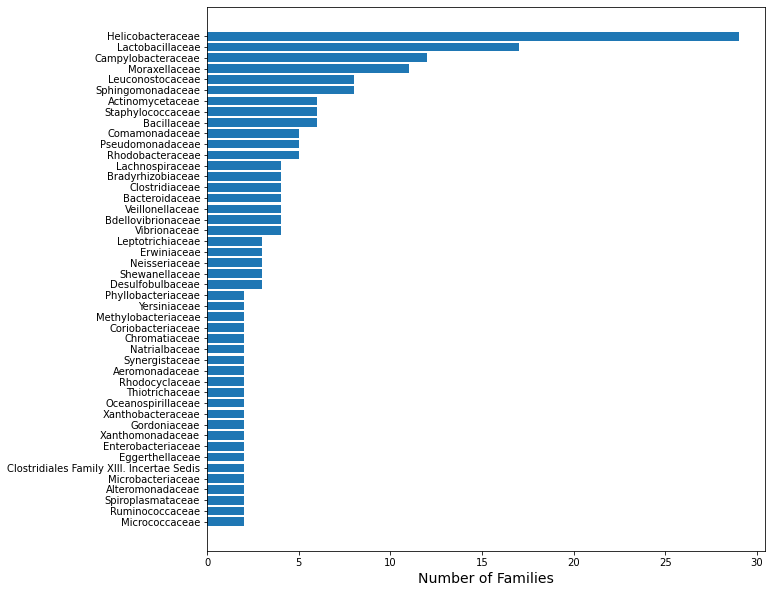

In [24]:
# Visualize KEGG counts for 16S data
fig, ax = plt.subplots(figsize=(10, 10))
taxa_counts = wgs_subpeek['family'].value_counts().sort_values(ascending=True)
# only focus on highly representive pathways
taxa_counts = taxa_counts.loc[taxa_counts > 1] 
ax.barh(taxa_counts.index, taxa_counts.values)
ax.set_xlabel('Number of Families', fontsize=14)

In [25]:
wgs_subpeek['family'].value_counts()

Helicobacteraceae                            29
Lactobacillaceae                             17
Campylobacteraceae                           12
Moraxellaceae                                11
Leuconostocaceae                              8
Sphingomonadaceae                             8
Actinomycetaceae                              6
Staphylococcaceae                             6
Bacillaceae                                   6
Rhodobacteraceae                              5
Comamonadaceae                                5
Pseudomonadaceae                              5
Lachnospiraceae                               4
Bradyrhizobiaceae                             4
Clostridiaceae                                4
Bacteroidaceae                                4
Veillonellaceae                               4
Bdellovibrionaceae                            4
Vibrionaceae                                  4
Shewanellaceae                                3
Desulfobulbaceae                        

In [26]:
len(wgs_subpeek)

285